In [58]:
molecule_name = "n2"
basis = "6-31g"
nelectron, norb = 10, 16

# molecule_name = "n2"
# basis = "sto-6g"
# nelectron, norb = 10, 8



molecule_basename = f"{molecule_name}_{basis}_{nelectron}e{norb}o"

bond_distance = 1.0

from molecules_catalog.util import load_molecular_data
from pathlib import Path
import os
from ffsim.variational.util import interaction_pairs_spin_balanced
import ffsim
from compressed_t2_multi_stage import from_t_amplitudes_compressed

# Get molecular data and molecular Hamiltonian
molecules_catalog_dir = "/home/WanHsuan.Lin/molecules-catalog"

mol_data = load_molecular_data(
    f"{molecule_basename}_d-{bond_distance:.5f}",
    molecules_catalog_dir=molecules_catalog_dir,
)
norb = mol_data.norb
nelec = mol_data.nelec
mol_hamiltonian = mol_data.hamiltonian

# Initialize Hamiltonian, initial state, and LUCJ parameters
hamiltonian = ffsim.linear_operator(mol_hamiltonian, norb=norb, nelec=nelec)
reference_state = ffsim.hartree_fock_state(norb, nelec)
pairs_aa, pairs_ab = interaction_pairs_spin_balanced("square", norb)

n_reps = 1
# use CCSD to initialize parameters
operator, init_loss, final_loss = from_t_amplitudes_compressed(
    mol_data.ccsd_t2,
    n_reps=n_reps,
    t1=mol_data.ccsd_t1,
    interaction_pairs=(pairs_aa, pairs_ab),
    optimize=True,
    multi_stage_optimization=True,
    step=5
)

import pickle 

from qiskit.circuit import QuantumCircuit, QuantumRegister
qubits = QuantumRegister(2 * norb)
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(operator), qubits)
# change to quimb
# Sample using quimb
decomposed = circuit.decompose(reps=2)


print(f"init loss: {init_loss}")
print(f"final loss: {final_loss}")

final loss: 0.0002515725209377706
final loss: 2.064484760921914e-05
final loss: 1.0078990271722432e-05
final loss: 1.2745334061037283e-05
final loss: 1.5455275388376322e-06
final loss: 9.739956112753134e-06


KeyboardInterrupt: 

In [ ]:
import quimb.tensor
from qiskit_quimb import quimb_circuit
import quimb.tensor.belief_propagation as qbp

# change to quimb
# Sample using quimb
# # Convert it to a quimb circuit
quimb_circ = quimb_circuit(decomposed)

# quimb_circ.psi.draw(color=['H', 'CX', 'XX+YY', 'CPhase'])
quimb_circ = quimb_circuit(
        decomposed,
        quimb_circuit_class=quimb.tensor.CircuitPermMPS,
        max_bond=10,
        cutoff=1e-3,
        progbar=True,
    )

sample = quimb_circ.sample(10, seed=0)


max_bond=9, error~=0.364: 100%|##########| 248/248 [00:06<00:00, 36.72it/s]   


In [ ]:
import quimb.tensor
from qiskit_quimb import quimb_circuit
import quimb.tensor.belief_propagation as qbp

# change to quimb
# Sample using quimb
# # Convert it to a quimb circuit
quimb_circ = quimb_circuit(decomposed)

# quimb_circ.psi.draw(color=['H', 'CX', 'XX+YY', 'CPhase'])
quimb_circ = quimb_circuit(
        decomposed,
        quimb_circuit_class=quimb.tensor.CircuitMPS,
        max_bond=10,
        cutoff=1e-3,
        progbar=True,
    )

sample = quimb_circ.sample(10, seed=0)


max_bond=8, error~=0.13: 100%|##########| 248/248 [00:00<00:00, 337.51it/s]    


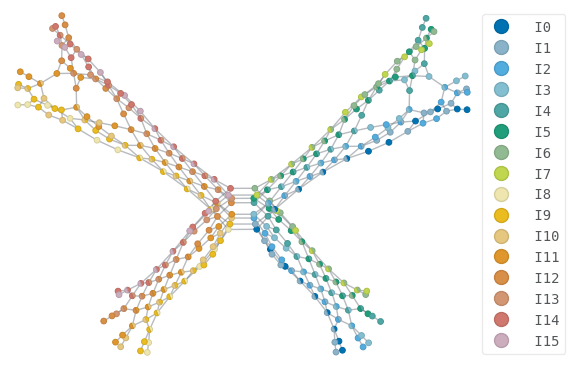

2


max|dM|=0.000161 nconv: 262/797 : : 97it [00:17,  5.52it/s]


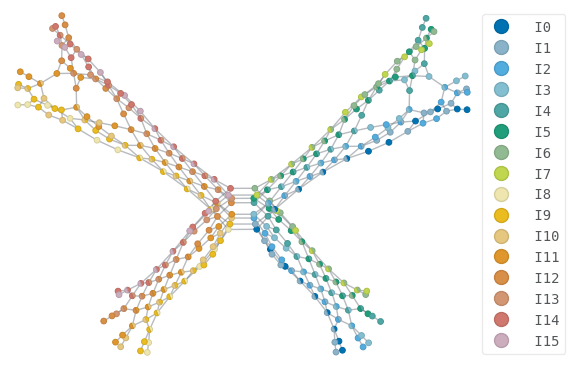

max|dM|=0.000161 nconv: 262/797 : : 97it [00:17,  5.55it/s]
/home/WanHsuan.Lin/lucj/.venv/lib/python3.10/site-packages/quimb/tensor/decomp.py:54: RuntimeWarning: divide by zero encountered in divide
  return x / reshape(d, (1, -1))
/home/WanHsuan.Lin/lucj/.venv/lib/python3.10/site-packages/quimb/tensor/decomp.py:54: RuntimeWarning: invalid value encountered in divide
  return x / reshape(d, (1, -1))
/home/WanHsuan.Lin/lucj/.venv/lib/python3.10/site-packages/quimb/tensor/decomp.py:1251: RuntimeWarning: invalid value encountered in matmul
  Pl = Rr @ rddiv(dag(VHt), st_sqrt)
/home/WanHsuan.Lin/lucj/.venv/lib/python3.10/site-packages/quimb/tensor/decomp.py:66: RuntimeWarning: divide by zero encountered in divide
  return x / reshape(d, (-1, 1))
/home/WanHsuan.Lin/lucj/.venv/lib/python3.10/site-packages/quimb/tensor/decomp.py:66: RuntimeWarning: invalid value encountered in divide
  return x / reshape(d, (-1, 1))
/home/WanHsuan.Lin/lucj/.venv/lib/python3.10/site-packages/quimb/tensor/decom

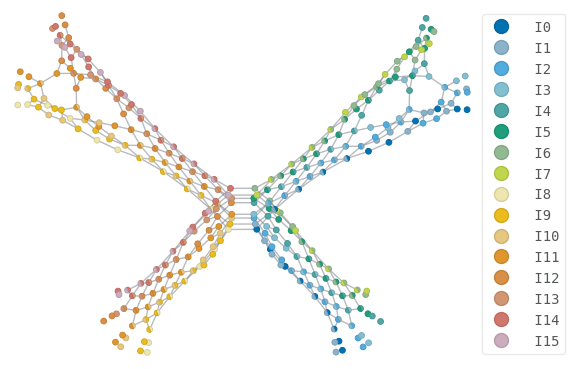

2


In [ ]:
quimb_circ = quimb_circuit(decomposed)
tn = quimb_circ.amplitude_tn(simplify_sequence="")
tn.draw(tn.site_tags)
print(tn.max_bond())

damping = 0.0
diis = True
info = {}
qbp.contract_d2bp(
    tn, damping=damping, diis=diis, info=info, progbar=True
)
tn.draw(tn.site_tags)

qbp.compress_d2bp(
        tn,
        max_bond=10,
        damping=damping,
        diis=diis,
        info=info,
        inplace=True,
        progbar=True,
    )
tn.draw(tn.site_tags)

print(tn.max_bond())
# assert tn.max_bond() == 2
# assert info["converged"]



In [ ]:
quimb_circ.update_params_from(tn)

import quimb.tensor as qtn
circ_mps = qtn.CircuitMPS(2 * norb,max_bond=10,
    cutoff=1e-3)
circ_mps.apply_gates(quimb_circ.gates, progbar=True)


sample = list(circ_mps.sample(10, seed=0))
print(sample)


max_bond=8, error~=0.13: 100%|##########| 248/248 [00:00<00:00, 375.57it/s]   


['1100111011101100', '1111100011111000', '1111100011111000', '1111100011101100', '1111100011111000', '1111100011111000', '1111100011111000', '1011101011111000', '1111100011111000', '1101101011111000']
